### Next sample strategy

Considered strategies used to propose the next problem:
1. Randomly sample from the dataset D. Does not model the student and is therefore unable to adapt to their ability. May present redundant teaching examples of concepts that have already been learned by the student and not reinforce concepts that the student has shown to be uncertain about.
2. ~~Worst predicted. Related to uncertainty sampling used in Active Learning. Selects the next teaching image whose prediction deviates most from the ground truth. Prone to proposing outliers. In the learning to program problem, maybe it presents the hardest exercises?~~
3. Expected Error Reduction. Chooses the teaching image which, if labeled correctly, would have the greatest reduction on the future error over the images that are not in the teaching set. Student’s conditional distribution given the teaching set can be approximated using Gaussian Random Field.

#### Import libraries

In [18]:
# Input
# from db import PythonProblems
import io

#DB
from questions.models import Solution, Cluster, UserLog
from django.contrib.auth.models import User

# Helpers
import numpy as np
import pickle

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Distance
# from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

# Learning
from clustering import Clustering
from plot2d import Plot2D
from questions.sampling import get_next_sample

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport

%matplotlib inline

In [7]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=132)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print(problems.count())
problems = Problem.objects.filter(id__lte=132)
problems.count()

591


132

In [8]:
solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')

In [9]:
solutions_obj.count()

54

In [10]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
# cursor = db.conn.cursor()
docs = []
docs_id = []
# doc_category = []
errors = []
questions = []
solutions = []

# lendo os dados
# cursor.execute("""
# SELECT solution.id, solution.content, problem.content, problem.category FROM solution, problem where solution.problem_id = problem.id;
# """)


for sol in solutions_obj:
    file = io.StringIO(sol.content)
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (sol.id))
    
    if doc == []:
        continue
    docs.append(' '.join(doc))
    docs_id.append(sol.id)
#     doc_category.append(row[-1])
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 54 documents
Success in parsing all documents! You may go on!


***Limitação do parser: variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

### Preprocessing solutions into bag of words ###

In [11]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
#                              stop_words = ['print'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.1
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
train_data_features = train_data_features.toarray()
train_data_features.shape

(54, 17)

In [12]:
feature_names = vectorizer.get_feature_names()
feature_names

['append',
 'def',
 'elif',
 'else',
 'false',
 'for',
 'if',
 'in',
 'int',
 'join',
 'len',
 'not',
 'number',
 'range',
 'return',
 'split',
 'true']

In [13]:
# Remove rows containing only zeros (weird exercises)
solution_sample = train_data_features[~(train_data_features==0).all(1)]
docs_id = np.asarray(docs_id)[~(train_data_features==0).all(1)]
# doc_category = np.asarray(doc_category)[~(train_data_features==0).all(1)]
questions = np.asarray(questions)[~(train_data_features==0).all(1)]
docs_id.shape

(54,)

### Cluster solutions

2209808447


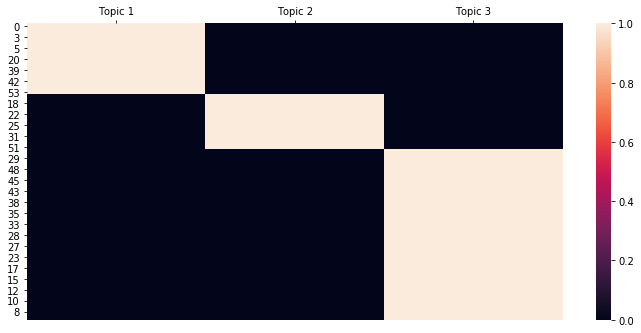

Count per class:
Topic 1: 13
Topic 2: 10
Topic 3: 31


In [14]:
# clustering = Clustering(handler.X, )
clustering = Clustering(solution_sample, 3)
clustering.seed = 2209808447
#2124056991
#232156180
#2539469571
# clustering.seed = 0
# clustering._generate_random_state()
model, document_topic, word_topic = clustering.gaussian_mixture()
print(clustering.seed)
clustering.plot_topic_distribution()

print("Count per class:")
counts = np.unique(clustering.document_topic.argmax(axis=1), return_counts=True)
for i in range(clustering.k):
    print("Topic %d: %d" % ((i+1), counts[1][i]))

In [15]:
def print_top_words(topic_word, feature_names, n_top_words):
    for topic_idx, topic in enumerate(topic_word):
        message = "Topic #%d: " % (topic_idx+1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [16]:
print("\nWords per topic:")
feature_names = vectorizer.get_feature_names()
print_top_words(word_topic, feature_names, 10)


Words per topic:
Topic #1: int return def join split for in if append len
Topic #2: elif return if def in else int number for not
Topic #3: in return for def if range number else false true



### Get next sample

Set initial matrices

In [19]:
# Create X as an empty belief state (X is the machine's model of the student's distribution)
X = np.zeros(clustering.document_topic.shape) # nS x nC
print(X.shape)

# Create Y as a document_topic matrix. For the first version, each document belongs to one topic
Y_col = clustering.document_topic.argmax(axis=1) # nS x nC
Y = np.zeros(clustering.document_topic.shape)
for idx in range(Y.shape[0]):
    Y[idx, Y_col[idx]] = 1

# Create W as a similarity matrix
W = cosine_similarity(clustering.X) # nS x nS
print(W.shape)

with open('similarity.pkl', 'wb') as picklefile:
    pickle.dump(W, picklefile)

# Set L as an unlabelled set
L = []

(54, 3)
(54, 54)


#### Visualization
Reduce to 2 dimensions using TSNE

14875623


/home/lmoraes/mt_env/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


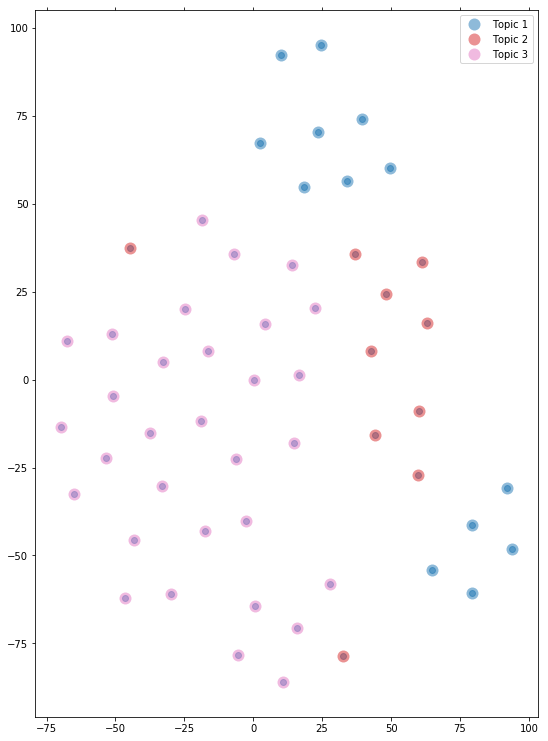

In [21]:
# %%time
# cluster_names = ['', 'conditional', 'dict', 'file', 'function', 'list', 'loop'] #'math', 'string']
cluster_names = ["Topic %d" % (i+1) for i in range(clustering.k)]
doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
handler = Plot2D(clusters=cluster_names, doc_category=doc_category, doc_id=docs_id)
#handler._generate_random_state()
handler.seed = 14875623
handler.reduce(solution_sample)
print(handler.seed)
handler.plot(show_clusters=True)

sample = handler.X
y = clustering.document_topic.argmax(axis=1)

# fig = plt.figure(figsize=(10,5))
# plt.scatter(x=sample[:,0], y=sample[:,1], c=y, s=100)

### Check if clusters are the same

In [31]:
solutions_obj = np.array(Solution.objects.filter(problem__in=problems, ignore=False).order_by('id').values_list('cluster', flat=True))
clusters = clustering.document_topic.argmax(axis=1)
(solutions_obj == clusters).all()

True

In [33]:
clustering.model

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=2209808447, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [34]:
handler.model

AttributeError: 'Plot2D' object has no attribute 'model'

### References
[1] Johns, E., Aodha, O. Mac & Brostow, G. J. Becoming the expert - Interactive multi-class machine teaching. in Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition (2015). doi:10.1109/CVPR.2015.7298877

[2] Zhu, X., Lafferty, J. & Ghahramani, Z. Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions Xiaojin. … Data Mach. Learn. … (2003).